In [1]:
#install these if the following cell does not execute
# pip install sortedcontainers
# pip install geopy


In [1]:
import networkx as nx
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import heapq
import random 
from sortedcontainers import SortedDict

from pyproj import Proj, transform
import geopy.distance
import seaborn as sns

import plotly
from plotly.offline import init_notebook_mode, plot, iplot, download_plotlyjs
import plotly.graph_objs as go
import plotly.io as pio
import cufflinks as cf

init_notebook_mode(connected=True)
cf.go_offline()

# Helper Functions 

In [2]:
def load_it_now(string_objectName):
    # load a pickled object like city networks that are needed as input later
    infile = open(string_objectName,'rb')
    ObjrctName = pickle.load(infile)
    infile.close()
    return ObjrctName

def get_node_pos_from_csv(filename):
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        isfirst = True
        positions = {}
        for row in csv_reader:
            if not isfirst:
                positions[int(row[0])] = (float(row[4]), float(row[5]))
            else:
                isfirst = False
        return positions

def get_state_path(state, J):
    route_edges = []
    while(state.get('prevstate') is not None):
        dest = state.get('node')
        org = state.get('prevstate').get('node')
        route_edges.append((org,dest))
        state = state.get('prevstate')
    return route_edges
    
def draw_state_path(state, J):
    node_pos = get_node_pos_from_csv('Postcode_centroids_ASM.csv')
    plt.figure(1, figsize=(13,13)) 
    nx.draw(J, pos = node_pos, node_size = 15)
    # Draw state path
    route_edges = get_state_path(state, J)

    # route edges is empty.. 
#     nx.draw_networkx_edges(J, node_pos, route_edges, edge_color='red', width=20)
#     plt.show()
    
        

# Bi-objective shortest path algorithm 
this computes the Pareto Fronts from one node to all other nodes of the network 

In [3]:
def compute_pareto_fronts(J, o):
    #------------------------------------------#
    #input:  aggregated network [networkx graph], node [int]
    #output: dictionary of all pareto fronts from node 'o' to all other nodes in the network [dictionary] 
    #this implements the multi-objective optimization criteria on all possible OD pairs from node 'o' to all 
    #other nodes of the network (thus it computes ParetoFronts based on distance and risk criteria)
    #------------------------------------------#

    states_to_explore = []
    best_length_risk_states_for_node = {o : SortedDict({0: 0})}
    
    states_to_explore = []
    cnt = 0
    heapq.heappush(states_to_explore, (0, 0, cnt, { 'distance': 0, 'risk': 0, 'prevstate': None, 'node': o }))
    
    while len(states_to_explore) > 0:
        current_distance, current_risk, dummy, current_state = heapq.heappop(states_to_explore)
        current_node = current_state.get('node')
        
        # Check if the explored path is still part of the optimal length risk curve.
        # Otherwise, discard.        
        best_length_risk_states = best_length_risk_states_for_node.get(current_node)
        if best_length_risk_states.get(current_distance, -1) != current_risk:
            continue
        
        for tt in J.out_edges(current_node):
            next_node = tt[1]
            edge = J[current_state.get('node')][next_node]
            
            best_length_risk_states = best_length_risk_states_for_node.get(next_node, None)
            if best_length_risk_states is None:
                best_length_risk_states = SortedDict()
                best_length_risk_states_for_node[next_node] = best_length_risk_states
            
            # Loop over different network choices for link
            for network_i in range(len(edge['distance'])):
                
                # Compute new length
                edge_length = edge['distance'][network_i]
                if edge_length == 0:
                    continue
                new_length = current_distance + edge_length
                
                # Compute new risk
                edge_risk = edge['risk'][network_i]
                new_risk = current_risk + edge_risk
                
                inserted = updateParetoFront(new_length, new_risk, best_length_risk_states)
                if not inserted:
                    continue
                
                new_state = { 'distance': new_length, 'risk': new_risk, 'prevstate': current_state, 'node': next_node}
                # Remove removed states from states_to_explore
                
                heapq.heappush(states_to_explore, (new_length, new_risk, cnt, new_state))
                cnt = cnt + 1
                
    return best_length_risk_states_for_node


In [4]:

def updateParetoFront(new_length, new_risk, best_length_risk_states):
    #------------------------------------------#
    # Input:  dist [int], risk[int], paretoFront [sorted dictionary]
    #output:[bolean] if the new_length and new_dist have been added to the ParetoFront returns True, False otherwise 
    # adds new dist, and new risk if the path is pareto optimal (non dominated) 
    #------------------------------------------#
    
    # Find before and after points on length-axis of relation
    after_idx = best_length_risk_states.bisect_right( new_length );
    before_idx = after_idx - 1;
    after_risk = -1
    before_risk = -1 
    
    # Find associated risks
    keys = best_length_risk_states.keys()
    if after_idx < len(best_length_risk_states):
        after_risk = best_length_risk_states.get(keys[after_idx])
    if before_idx >= 0:
        before_risk = best_length_risk_states.get(keys[before_idx])
       
    # Exclude new path if the shorter path has same or less risk
    if before_risk <= new_risk and not before_risk == -1:
        return False

    # Exclude longer or equal paths with higher risks:
    final_exclude_idx = after_idx
    while(final_exclude_idx < len(best_length_risk_states)):
        risk = best_length_risk_states.get(keys[final_exclude_idx])
        if risk < new_risk:
            break
        final_exclude_idx = final_exclude_idx + 1
    del best_length_risk_states.keys()[after_idx:final_exclude_idx]
    best_length_risk_states[new_length] = new_risk
    
    return True

##### Checking that the Pareto front is updated correctly: monotonously decreasing curve in the distance - risk space 

In [5]:
def testParetoFrontUpdate(dct, insert, expected):
    #------------------------------------------#
    # test update pareto front (explain more what is going on)
    # input: pareto front [sorted dictionary], additional pareto dominant path [tuple(distance,risk)], 
    # expected updated of pareto front [sorted dictionary]
    #output: 'OK' if pareto front is updated as a monotonously decreasing curve, 'Failed' otherwise
    #------------------------------------------#

    sd = SortedDict(dct) 
    updateParetoFront(insert[0],insert[1], sd) # this function modifies sd
    iscorrect = expected == sd
    print("OK" if iscorrect else "FAILED")

In [6]:
# testParetoFrontUpdate({1: 10, 3: 8, 5: 6, 7: 4}, (2, 9), {1: 10, 2: 9, 3: 8, 5: 6, 7: 4})
# testParetoFrontUpdate({1: 10, 3: 8, 5: 6, 7: 4}, (1, 11), {1: 10, 3: 8, 5: 6, 7: 4})
# testParetoFrontUpdate({1: 10, 3: 8, 5: 6, 7: 4}, (1, 9), {1: 9, 3: 8, 5: 6, 7: 4})
# testParetoFrontUpdate({1: 10, 3: 8, 5: 6, 7: 4}, (1, 6), {1: 6, 7: 4})
# testParetoFrontUpdate({1: 10, 3: 8, 5: 6, 7: 4}, (4, 6), {1: 10, 3: 8, 4: 6, 7: 4})
# testParetoFrontUpdate({1: 10, 3: 8, 5: 6, 7: 4}, (4, 8), {1: 10, 3: 8, 5: 6, 7: 4})
# testParetoFrontUpdate({1: 10, 3: 8, 5: 6, 7: 4}, (7, 4), {1: 10, 3: 8, 5: 6, 7: 4})
# testParetoFrontUpdate({1: 10, 3: 8, 5: 6, 7: 4}, (7, 5), {1: 10, 3: 8, 5: 6, 7: 4})
# testParetoFrontUpdate({1: 10, 3: 8, 5: 6, 7: 4}, (7, 3), {1: 10, 3: 8, 5: 6, 7: 3})
# testParetoFrontUpdate({1: 10, 3: 8, 5: 6, 7: 4}, (9, 5), {1: 10, 3: 8, 5: 6, 7: 4})
# testParetoFrontUpdate({1: 10, 3: 8, 5: 6, 7: 4}, (9, 3), {1: 10, 3: 8, 5: 6, 7: 4, 9: 3})
# testParetoFrontUpdate({1: 10, 3: 8, 5: 6, 7: 4}, (2.8, 0.1), {1: 10, 2.8: 0.1 })
# testParetoFrontUpdate({1: 10, 3: 8, 5: 6, 7: 4}, (0.6, 6), {0.6: 6, 7: 4})

# Import city graph and node positions

We will work with coarse-grained city network, rather than the Open Street Map (OSM) fine-grained network for two reasons: 1) to reduce the computation complexity of working with large scale networks, 2) to be less dependent on OSM inaccuracies, due to crowd sourced nature of the dataset.

Each edge of the coarse-grained graph has a 'distance' attribute equals to a quadruple [d_0,d_1,d_2,d_3] of values and an 'inefficiency' attribute set to zero (which will not be used in this code). The four distance values corresponds to the aggregated distance between two zoned, using the following OSM facility types:
- d_0: bike lanes and bike tracks,
- d_1: bike lanes, bike tracks and residential streets,
- d_2: all streets where cycling is allowed by city laws,
- d_2: car streets. 

 

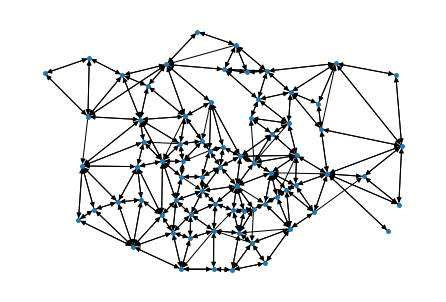

In [7]:
J=load_it_now('AMS_coaresned_graph')
node_pos = get_node_pos_from_csv('Postcode_centroids_ASM.csv')

#nodes of the “Amsterdam-Zuidoost” area are removed  since it is a disconnected component of the network
disconnected_component_nodes=(1,2,3,4,5,6,7,8,9)
J.remove_nodes_from(disconnected_component_nodes)

#draw network 
nx.draw(J, pos = node_pos, node_size = 15)


# Risk definition

In [8]:
def assign_weights(J,types):
    #------------------------------------------#
    #input: network with 'distance' attribute and type of risk function to apply
    # output: netowrk with 'distance' and 'risk' attribute
    # assigns risk (or discomfort) attribute to each edge of the network
    # risk is a quadruple of values, just like distance, one relative to each 'street-layer' considered 
    #------------------------------------------#
    if types=='Linear':
        for edge in J.edges:
            beta = [None]*4
            beta[0] = J[edge[0]][edge[1]]['distance'][0]
            beta[1] = J[edge[0]][edge[1]]['distance'][1]*0.66
            beta[2] = J[edge[0]][edge[1]]['distance'][2]*0.33
            beta[3] = 0
            J[edge[0]][edge[1]]['risk'] = beta
    return J

J=assign_weights(J,'Linear')

# Example of one bikeability curve 
(absolute sclae)

SortedValuesView(SortedDict({7112.590103471454: 3374.3279582706996, 7206.51649168078: 2443.061242821487, 7294.136292408697: 2160.737821806267, 7388.062680618023: 1229.4711063570549, 8150.9000064346355: 1023.8725334508131, 8748.921805332904: 483.54908719693907, 11157.454553656487: 0}))


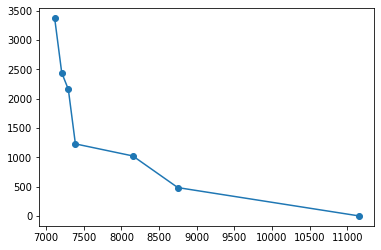

In [9]:
sp = compute_pareto_fronts(J,50)
length_risk_curve = sp.get(70)

print(length_risk_curve.values())
plt.plot(length_risk_curve.keys(), length_risk_curve.values(), marker='o', linestyle='solid')

# Normalise bikeability curves 

In [10]:
def airline_distance(a,b):
    # input: nodes positions as tuples of (xcoord,ycoord) extrapolated from CSV file via 'get_node_pos_from_csv' function
    # output: Euclidean distance between the nodes 
    inProj = Proj('epsg:32631')
    outProj = Proj('epsg:4326')

    ax_proj,ay_proj = transform(inProj,outProj,a[0],a[1])
    bx_proj,by_proj = transform(inProj,outProj,b[0],b[1])
#     print (ax_proj,ay_proj)
#     print (bx_proj,by_proj)
    air_dist=geopy.distance.geodesic       ((ax_proj,ay_proj), (bx_proj,by_proj)).km*1000
    return air_dist

# airline_distance(node_pos[5],node_pos[6])

In [11]:
def normalise_and_add_bikeability_curve(graph, orig, dest, output_data, color='royalblue',): 
    #------------------------------------------#
    #input: graph [networkx graph], orig node [int], dest node [int], output data [list] used for plotly graphs
    #ouput: output data with a new (normalised) bikeability curve appended to it
    # normalises bikeability vurve and appends it to the output_data list
    #------------------------------------------#
    sp = compute_pareto_fronts(graph,orig)
    length_risk_curve = sp.get(dest)
    air_dist=airline_distance(node_pos[orig],node_pos[dest])
    
    # use these commented lines if you want to normalise based on shortest available route 
    # normalising compared to shortest route available avoids penaliseing cities with imposed natural detours rivers or canals
#     rel_dist=np.array(length_risk_curve.keys())/min(length_risk_curve.keys())
#     rel_risk=np.array(length_risk_curve.values())/min(length_risk_curve.keys())
    
    rel_dist=np.array(length_risk_curve.keys())/air_dist
    rel_risk=np.array(length_risk_curve.values())/air_dist

    output_data.append(go.Scatter(x = rel_dist, y= rel_risk,
                                marker=dict(color=color,size=7,opacity=0.9),
                                opacity=0.5,
                                line=dict(color= color,width=1.3), 
                                mode = 'markers+lines',showlegend=False))   
    return output_data


# Compute and Plot Bikeability curves for Amsterdam 

In [12]:
def compute_bikeability_curves(num_curves=0):
    #------------------------------------------#
    #input: number of OD pairs to compute bikeability curves for
    #num curves=0 maens compute for all possible combinations of OD pairs. 
    #so if the network has 10 nodes it wil compute 100 bikeability curves 
    # if num_curves=3 it computes bikeability curves for 3 random OD pairs. 
    #------------------------------------------#
    data_plot=[]
    if num_curves==0: 
        for orig in J.nodes:
            for dest in J.nodes:
                if orig!=dest:
                    if nx.has_path(J, orig, dest):
                        data_plot=normalise_and_add_bikeability_curve(J, orig , dest, output_data=data_plot)
    
    else:    
        k=0
        random.seed(1994)
        while k <num_curves:
            k+=1
            orig=random.randint(10, len(J.nodes))
            dest=random.randint(10, len(J.nodes))
            data_plot=normalise_and_add_bikeability_curve(J, orig , dest, output_data=data_plot)
    return data_plot


In [13]:

data_plot=compute_bikeability_curves(num_curves= 3)

layout = go.Layout(title= 'Amsterdam',title_x=0.5,title_y=0.85, grid=dict(pattern='independent'),
                   xaxis=dict(range=[0.8,6],title='Relative Distance'),
                   yaxis=dict(range=[-0.08,1.5],title ='Relative Discomfort' ),
                  width=500, height=500)

iplot({"data":data_plot,"layout":layout})

# Bikeability tables 

In [14]:
def compute_table_ratios(bike_curves, min_risk, max_risk, risk_len, min_dist, max_dist, dist_len):
    #------------------------------------------#
    #input: bikeability curves [list], risk minimum value, risk maximum value, amount of risk values, 
    #inout: distance minimum value, distance maximum value, amount of distance values, 
    #output: dataframe with ration of amount of ODpairs that have at least one path below or equal 
    # to the correspontding risk and distance value in the row and column header 
    #------------------------------------------#
    risk_list=[list(i.y) for i in bike_curves]
    dist_list=[list(i.x) for i in bike_curves]
    r_len ,d_len = risk_len,dist_len
    counter = np.zeros((r_len ,d_len))
    for r_idx,r in enumerate(np.linspace(min_risk, max_risk,r_len)):
        for d_idx,d in enumerate(np.linspace(min_dist, max_dist, d_len)):
            counter_i =0
            for r_i,d_i in zip(risk_list, dist_list):
                counter_i += int(np.sum((np.array(r_i)<=r) & (np.array(d_i)<=d))>0)
            counter[r_idx,d_idx] = counter_i
    counter = counter /len(risk_list) 
    counter=np.around(counter,2)
    df = pd.DataFrame(counter, index=["%.2f"%i for i in np.linspace(min_risk, max_risk,r_len)], columns = ["%.2f"%i for i in np.linspace(min_dist, max_dist,d_len)])
    return df 


In [15]:
# set color map for the table 
cm = sns.light_palette("black", as_cmap=True)

# set row and column values for tha table
df= compute_table_ratios(data_plot, 0, 2, 10, 1, 4, 10)
s = df.style.background_gradient(cmap=cm, low = np.min(df.min(axis=0)),axis=None )
s

,1.00,1.33,1.67,2.00,2.33,2.67,3.00,3.33,3.67,4.00
0.00,0,0,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33
0.22,0,0,0.67,0.67,0.67,0.67,0.67,0.67,0.67,1
0.44,0,0.33,0.67,0.67,0.67,0.67,0.67,0.67,1,1
0.67,0,0.33,0.67,0.67,0.67,0.67,0.67,1,1,1
0.89,0,0.33,0.67,0.67,0.67,0.67,0.67,1,1,1
1.11,0,0.33,0.67,0.67,0.67,0.67,0.67,1,1,1
1.33,0,0.33,0.67,0.67,0.67,0.67,0.67,1,1,1
1.56,0,0.33,0.67,0.67,0.67,0.67,0.67,1,1,1
1.78,0,0.33,0.67,0.67,0.67,0.67,0.67,1,1,1
2.00,0,0.33,0.67,0.67,0.67,0.67,0.67,1,1,1


# Network-wide Bikeability curve 
An approach that transforms the set of Pareto fronts (bikeability curves) into one single network-wide bikeability curve. This curve contains for all possible distance-risk trade-off choices, the expected distance and discomfort of the optimal route for an OD-pair that is sampled from an OD-demand distribution.

We present an approach that incorporates all the different individual preferences (thus utility functions) and shows how bikeable the network is according to the different users.

In [16]:
def utility(risk,dist,alpha): 
    # utility function of the users
    return alpha*risk+dist

users=np.linspace(0.01,100,2000)

def network_wide_bikeability_curve(betas, bike_curves):
    #------------------------------------------#
    #input: beta preference of users [int], list of bikeability curves [list]
    #output: dictionary={beta: [average optimal utility value, average optimal distance, average optimal risk]}
    #computes optimal values on the pareto front for each specific user preference value beta
    #------------------------------------------#
    risk_list=[list(i.y) for i in bike_curves]
    dist_list=[list(i.x) for i in bike_curves]
    user_dict={}

    for u in betas: 
    # for each user preference we fill in the dictionary[alpha:[optimas, optima_dist,optima_risk]
        optima=[]
        opt_dist=[]
        opt_risk=[]
        for i in np.arange(len(risk_list)):
            a=[u]*len(risk_list[i])
            result = min(list(map(utility,risk_list[i],dist_list[i],a)))
            best_index=np.argmin(list(map(utility,risk_list[i],dist_list[i],a)))

            optima.append(result)
            opt_dist.append(dist_list[i][best_index])
            opt_risk.append(risk_list[i][best_index])
        np.mean(optima)
        user_dict[u]=[np.mean(optima),np.mean(opt_dist), np.mean(opt_risk)]
    return user_dict

In [17]:
user_dict=network_wide_bikeability_curve(users, data_plot)

data_plot.append(go.Scatter(x= np.array([data[1] for _,data in user_dict.items()]),
                            y=np.array([data[2] for _,data in user_dict.items()]),
                            marker=dict(color='black',size=10),
#                             line=dict(color='black',width=2), 
                            mode = 'markers',showlegend=False))


In [18]:
iplot({"data":data_plot,"layout":layout})